In [1]:
import os
from tqdm import tqdm
from timeit import default_timer as timer

os.environ["OMP_NUM_THREADS"] = "1"  # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "1"  # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1"  # export NUMEXPR_NUM_THREADS=6

import numpy as np
import sisl
from src.grogu_magn.useful import *
from mpi4py import MPI
from numpy.linalg import inv
import warnings

# runtime information
times = dict()
times["start_time"] = timer()
########################
# it works if data is in downloads folder
########################
sisl.__version__

[Mac:23435] shmem: mmap: an error occurred while determining whether or not /var/folders/yh/dx7xl94n3g52ts3td8qcxjcc0000gn/T//ompi.Mac.501/jf.0/46137344/sm_segment.Mac.501.2c00000.0 could be created.


'0.14.3'

In [2]:
# this cell mimicks an input file
fdf = sisl.get_sile(
    "/Users/danielpozsar/Downloads/nojij/Fe3GeTe2/monolayer/soc/lat3_791/Fe3GeTe2.fdf"
)  # ./Jij_for_Marci_6p45ang/CrBr.fdf
# this information needs to be given at the input!!
scf_xcf_orientation = np.array([0, 0, 1])  # z
# list of reference directions for around which we calculate the derivatives
# o is the quantization axis, v and w are two axes perpendicular to it
# at this moment the user has to supply o,v,w on the input.
# we can have some default for this
ref_xcf_orientations = [
    dict(o=np.array([1, 0, 0]), vw=[np.array([0, 1, 0]), np.array([0, 0, 1])]),
    dict(o=np.array([0, 1, 0]), vw=[np.array([1, 0, 0]), np.array([0, 0, 1])]),
    dict(o=np.array([0, 0, 1]), vw=[np.array([1, 0, 0]), np.array([0, 1, 0])]),
]


# human readable definition of magnetic entities ./lat3_791/Fe3GeTe2.fdf
magnetic_entities = [
    dict(atom=3, l=2),
    dict(atom=4, l=2),
    dict(atom=5, l=2),
    #    dict(atom=[3, 4],),
]
# pair information ./lat3_791/Fe3GeTe2.fdf
pairs = [
    # isotropic should be -82 meV
    dict(ai=0, aj=1, Ruc=np.array([0, 0, 0])),
    #    dict(ai=1, aj=0, Ruc=np.array([0, 0, 0])),
    dict(ai=1, aj=2, Ruc=np.array([0, 0, 0])),
    #    dict(ai=2, aj=1, Ruc=np.array([0, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([0, 0, 0])),
    #    dict(ai=2, aj=0, Ruc=np.array([0, 0, 0])),
    # these should all be around -41.9 in the isotropic part
    #    dict(ai=0, aj=2, Ruc=np.array([0, 0, 0])),
    #    dict(ai=1, aj=2, Ruc=np.array([0, 0, 0])),
    #    dict(ai=0, aj=2, Ruc=np.array([-1, 0, 0])),
    #    dict(ai=1, aj=2, Ruc=np.array([-1, 0, 0])),
]

"""
# human readable definition of magnetic entities ./Jij_for_Marci_6p45ang/CrBr.fdf
magnetic_entities = [
    dict(atom=0, l=2),
    dict(atom=1, l=2),
    dict(atom=2, l=2),
]
# pair information ./Jij_for_Marci_6p45ang/CrBr.fdf
pairs = [
    dict(ai=0, aj=1, Ruc=np.array([0, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([0, 0, 0])),
    dict(ai=1, aj=2, Ruc=np.array([0, 0, 0])),
    dict(ai=0, aj=1, Ruc=np.array([1, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([1, 0, 0])),
    dict(ai=0, aj=1, Ruc=np.array([-1, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([-1, 0, 0])),
    dict(ai=0, aj=1, Ruc=np.array([0, 1, 0])),
    dict(ai=0, aj=2, Ruc=np.array([0, 1, 0])),
    dict(ai=0, aj=1, Ruc=np.array([0, 1, 0])),
    dict(ai=0, aj=2, Ruc=np.array([0, 1, 0])),
]
"""

# Brilloun zone sampling and Green function contour integral
kset = 10
kdirs = "xy"
ebot = -15
eset = 50
esetp = 1000


# MPI parameters
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
root_node = 0

simulation_parameters = dict(
    path="Not yet specified.",
    scf_xcf_orientation=scf_xcf_orientation,
    ref_xcf_orientations=ref_xcf_orientations,
    kset=kset,
    kdirs=kdirs,
    ebot=ebot,
    eset=eset,
    esetp=esetp,
    parallel_size=size,
)

# digestion of the input
# read in hamiltonian
dh = fdf.read_hamiltonian()
simulation_parameters["cell"] = fdf.read_geometry().cell

# unit cell index
uc_in_sc_idx = dh.lattice.sc_index([0, 0, 0])

print_parameters(simulation_parameters)
times["setup_time"] = timer()

Input file: 
Not yet specified.
Number of nodes in the parallel cluster:  1
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
Parameters for the contour integral:
Number of k points:  10
k point directions:  xy
Ebot:  -15
Eset:  50
Esetp:  1000


/Users/danielpozsar/Documents/oktatás/elte/phd/grogu_project/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/danielpozsar/Documents/oktatás/elte/phd/grogu_project/.venv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


-12.806739

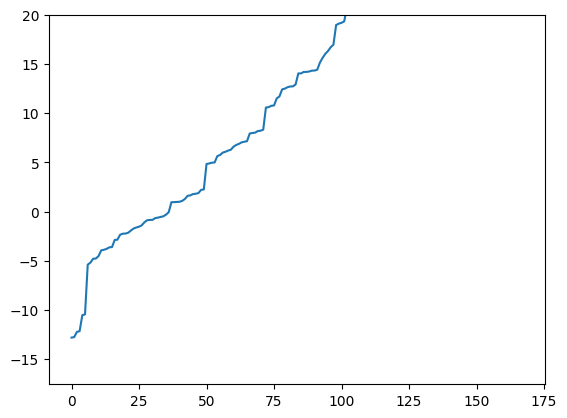

In [3]:
import matplotlib.pyplot as plt

plt.plot(np.sort(dh.eig()))
plt.ylim(None, 20)
np.real(dh.eig()).min()

In [4]:
NO = dh.no  # shorthand for number of orbitals in the unit cell

# preprocessing Hamiltonian and overlap matrix elements
h11 = dh.tocsr(dh.M11r)
h11 += dh.tocsr(dh.M11i) * 1.0j
h11 = h11.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h22 = dh.tocsr(dh.M22r)
h22 += dh.tocsr(dh.M22i) * 1.0j
h22 = h22.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h12 = dh.tocsr(dh.M12r)
h12 += dh.tocsr(dh.M12i) * 1.0j
h12 = h12.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h21 = dh.tocsr(dh.M21r)
h21 += dh.tocsr(dh.M21i) * 1.0j
h21 = h21.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

sov = (
    dh.tocsr(dh.S_idx)
    .toarray()
    .reshape(NO, dh.n_s, NO)
    .transpose(0, 2, 1)
    .astype("complex128")
)


# Reorganization of Hamiltonian and overlap matrix elements to SPIN BOX representation
U = np.vstack(
    [np.kron(np.eye(NO, dtype=int), [1, 0]), np.kron(np.eye(NO, dtype=int), [0, 1])]
)
# This is the permutation that transforms ud1ud2 to u12d12
# That is this transforms FROM SPIN BOX to ORBITAL BOX => U
# the inverse transformation is U.T u12d12 to ud1ud2
# That is FROM ORBITAL BOX to SPIN BOX => U.T

# From now on everything is in SPIN BOX!!
hh, ss = np.array(
    [
        U.T @ np.block([[h11[:, :, i], h12[:, :, i]], [h21[:, :, i], h22[:, :, i]]]) @ U
        for i in range(dh.lattice.nsc.prod())
    ]
), np.array(
    [
        U.T
        @ np.block([[sov[:, :, i], sov[:, :, i] * 0], [sov[:, :, i] * 0, sov[:, :, i]]])
        @ U
        for i in range(dh.lattice.nsc.prod())
    ]
)


# symmetrizing Hamiltonian and overlap matrix to make them hermitian
for i in range(dh.lattice.sc_off.shape[0]):
    j = dh.lattice.sc_index(-dh.lattice.sc_off[i])
    h1, h1d = hh[i], hh[j]
    hh[i], hh[j] = (h1 + h1d.T.conj()) / 2, (h1d + h1.T.conj()) / 2
    s1, s1d = ss[i], ss[j]
    ss[i], ss[j] = (s1 + s1d.T.conj()) / 2, (s1d + s1.T.conj()) / 2

# identifying TRS and TRB parts of the Hamiltonian
TAUY = np.kron(np.eye(NO), tau_y)
hTR = np.array([TAUY @ hh[i].conj() @ TAUY for i in range(dh.lattice.nsc.prod())])
hTRS = (hh + hTR) / 2
hTRB = (hh - hTR) / 2

# extracting the exchange field
traced = [spin_tracer(hTRB[i]) for i in range(dh.lattice.nsc.prod())]  # equation 77
XCF = np.array(
    [
        np.array([f["x"] for f in traced]),
        np.array([f["y"] for f in traced]),
        np.array([f["z"] for f in traced]),
    ]
)  # equation 77

# Check if exchange field has scalar part
max_xcfs = abs(np.array(np.array([f["c"] for f in traced]))).max()
if max_xcfs > 1e-12:
    warnings.warn(
        f"Exchange field has non negligible scalar part. Largest value is {max_xcfs}"
    )

times["H_and_XCF_time"] = timer()

In [5]:
# for every site we have to store 3 Greens function (and the associated _tmp-s) in the 3 reference directions
for i, mag_ent in enumerate(magnetic_entities):
    parsed = parse_magnetic_entity(dh, **mag_ent)  # parse orbital indexes
    magnetic_entities[i]["orbital_indeces"] = parsed
    # calculate spin box indexes
    magnetic_entities[i]["spin_box_indeces"] = blow_up_orbindx(parsed)
    # if orbital is not set use all
    if "l" not in mag_ent.keys():
        mag_ent["l"] = "all"
    if isinstance(mag_ent["atom"], int):
        mag_ent["tags"] = [
            f"[{mag_ent['atom']}]{dh.atoms[mag_ent['atom']].tag}({mag_ent['l']})"
        ]
        mag_ent["xyz"] = [dh.xyz[mag_ent["atom"]]]
    if isinstance(mag_ent["atom"], list):
        mag_ent["tags"] = []
        mag_ent["xyz"] = []
        # iterate over atoms
        for atom_idx in mag_ent["atom"]:
            mag_ent["tags"].append(
                f"[{atom_idx}]{dh.atoms[atom_idx].tag}({mag_ent['l']})"
            )
            mag_ent["xyz"].append(dh.xyz[atom_idx])

    # calculate size for Greens function generation
    spin_box_shape = len(mag_ent["spin_box_indeces"])

    mag_ent["energies"] = []  # we will store the second order energy derivations here

    mag_ent["Gii"] = []  # Greens function
    mag_ent["Gii_tmp"] = []  # Greens function for parallelization
    # These will be the perturbed potentials from eq. 100
    mag_ent["Vu1"] = [list([]) for _ in range(len(ref_xcf_orientations))]
    mag_ent["Vu2"] = [list([]) for _ in range(len(ref_xcf_orientations))]
    for i in ref_xcf_orientations:
        # Greens functions for every quantization axis
        mag_ent["Gii"].append(
            np.zeros((eset, spin_box_shape, spin_box_shape), dtype="complex128")
        )
        mag_ent["Gii_tmp"].append(
            np.zeros((eset, spin_box_shape, spin_box_shape), dtype="complex128")
        )

# for every site we have to store 2x3 Greens function (and the associated _tmp-s)
# in the 3 reference directions, because G_ij and G_ji are both needed
for pair in pairs:
    # calculate size for Greens function generation
    spin_box_shape_i = len(magnetic_entities[pair["ai"]]["spin_box_indeces"])
    spin_box_shape_j = len(magnetic_entities[pair["aj"]]["spin_box_indeces"])
    pair["tags"] = []
    for mag_ent in [magnetic_entities[pair["ai"]], magnetic_entities[pair["aj"]]]:
        tag = ""
        # get atoms of magnetic entity
        atoms_idx = mag_ent["atom"]
        orbitals = mag_ent["l"]

        # if magnetic entity contains one atoms
        if isinstance(atoms_idx, int):
            tag += f"[{atoms_idx}]{dh.atoms[atoms_idx].tag}({orbitals})"

        # if magnetic entity contains more than one atoms
        if isinstance(atoms_idx, list):
            # iterate over atoms
            atom_group = "{"
            for atom_idx in atoms_idx:
                atom_group += f"[{atom_idx}]{dh.atoms[atom_idx].tag}({orbitals})--"
            # end {} of the atoms in the magnetic entity
            tag += atom_group[:-2] + "}"
        pair["tags"].append(tag)
    pair["energies"] = []  # we will store the second order energy derivations here

    pair["Gij"] = []  # Greens function
    pair["Gji"] = []
    pair["Gij_tmp"] = []  # Greens function for parallelization
    pair["Gji_tmp"] = []
    for i in ref_xcf_orientations:
        # Greens functions for every quantization axis
        pair["Gij"].append(
            np.zeros((eset, spin_box_shape_i, spin_box_shape_j), dtype="complex128")
        )
        pair["Gij_tmp"].append(
            np.zeros((eset, spin_box_shape_i, spin_box_shape_j), dtype="complex128")
        )
        pair["Gji"].append(
            np.zeros((eset, spin_box_shape_j, spin_box_shape_i), dtype="complex128")
        )
        pair["Gji_tmp"].append(
            np.zeros((eset, spin_box_shape_j, spin_box_shape_i), dtype="complex128")
        )

times["site_and_pair_dictionaries_time"] = timer()

In [6]:
kset = make_kset(dirs=kdirs, NUMK=kset)  # generate k space sampling
wkset = np.ones(len(kset)) / len(kset)  # generate weights for k points
kpcs = np.array_split(kset, size)  # split the k points based on MPI size
kpcs[root_node] = tqdm(kpcs[root_node], desc="k loop")

times["k_set_time"] = timer()

k loop:   0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
# this will contain the three hamiltonians in the reference directions needed to calculate the energy variations upon rotation
hamiltonians = []

# iterate over the reference directions (quantization axes)
for i, orient in enumerate(ref_xcf_orientations):
    # obtain rotated exchange field
    R = RotMa2b(scf_xcf_orientation, orient["o"])
    rot_XCF = np.einsum("ij,jklm->iklm", R, XCF)
    rot_H_XCF = sum(
        [np.kron(rot_XCF[i], tau) for i, tau in enumerate([tau_x, tau_y, tau_z])]
    )
    rot_H_XCF_uc = rot_H_XCF[uc_in_sc_idx]

    # obtain total Hamiltonian with the rotated exchange field
    rot_H = (
        hTRS + rot_H_XCF
    )  # equation 76 #######################################################################################

    hamiltonians.append(
        dict(orient=orient["o"], H=rot_H)
    )  # store orientation and rotated Hamiltonian

    # these are the infinitezimal rotations (for now) perpendicular to the quantization axis
    for u in orient["vw"]:
        Tu = np.kron(np.eye(NO, dtype=int), tau_u(u))  # section 2.H

        Vu1 = 1j / 2 * commutator(rot_H_XCF_uc, Tu)  # equation 100
        Vu2 = 1 / 8 * commutator(commutator(Tu, rot_H_XCF_uc), Tu)  # equation 100

        for mag_ent in magnetic_entities:
            # fill up the perturbed potentials (for now) based on the on-site projections
            mag_ent["Vu1"][i].append(
                Vu1[:, mag_ent["spin_box_indeces"]][mag_ent["spin_box_indeces"], :]
            )
            mag_ent["Vu2"][i].append(
                Vu2[:, mag_ent["spin_box_indeces"]][mag_ent["spin_box_indeces"], :]
            )

times["reference_rotations_time"] = timer()

In [ ]:
if rank == root_node:
    print("Starting matrix inversions")
    print(f"Total number of k points: {kset.shape[0]}")
    print(f"Total number of directions: {len(hamiltonians)}")
    print(f"Total number of matrix inversions: {kset.shape[0] * len(hamiltonians)}")
    print(f"The shape of the Hamiltonian and the Greens function is {NO}x{NO}={NO*NO}")
    print(
        "================================================================================================================================================================"
    )

comm.Barrier()
# ----------------------------------------------------------------------

# make energy contour
# we are working in eV now  !
# and sisil shifts E_F to 0 !
cont = make_contour(emin=ebot, enum=eset, p=esetp)
eran = cont.ze

# ----------------------------------------------------------------------
# sampling the integrand on the contour and the BZ
for k in kpcs[rank]:
    wk = wkset[rank]  # weight of k point in BZ integral
    # iterate over reference directions
    for i, hamiltonian_orientation in enumerate(hamiltonians):
        # calculate Greens function
        H = hamiltonian_orientation["H"]
        HK, SK = hsk(H, ss, dh.sc_off, k)
        # Gk = inv(SK * eran.reshape(eset, 1, 1) - HK)

        # solve Greens function sequentially for the energies, because of memory bound
        Gk = np.zeros(shape=(eset, HK.shape[0], HK.shape[1]), dtype="complex128")
        for j in range(eset):
            Gk[j] = inv(SK * eran[j] - HK)

        # store the Greens function slice of the magnetic entities (for now) based on the on-site projections
        for mag_ent in magnetic_entities:
            mag_ent["Gii_tmp"][i] += (
                Gk[:, mag_ent["spin_box_indeces"]][..., mag_ent["spin_box_indeces"]]
                * wk
            )

        for pair in pairs:
            # add phase shift based on the cell difference
            phase = np.exp(1j * 2 * np.pi * k @ pair["Ruc"].T)

            # get the pair orbital sizes from the magnetic entities
            ai = magnetic_entities[pair["ai"]]["spin_box_indeces"]
            aj = magnetic_entities[pair["aj"]]["spin_box_indeces"]

            # store the Greens function slice of the magnetic entities (for now) based on the on-site projections
            pair["Gij_tmp"][i] += Gk[:, ai][..., aj] * phase * wk
            pair["Gji_tmp"][i] += Gk[:, aj][..., ai] * phase * wk

# summ reduce partial results of mpi nodes
for i in range(len(hamiltonians)):
    for mag_ent in magnetic_entities:
        comm.Reduce(mag_ent["Gii_tmp"][i], mag_ent["Gii"][i], root=root_node)

    for pair in pairs:
        comm.Reduce(pair["Gij_tmp"][i], pair["Gij"][i], root=root_node)
        comm.Reduce(pair["Gji_tmp"][i], pair["Gji"][i], root=root_node)

times["green_function_inversion_time"] = timer()

Total number of k points: 100
Total number of directions: 3
Total number of matrix inversions: 300
The shape of the Hamiltonian and the Greens function is 84x84=7056


k loop: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


In [9]:
if rank == root_node:
    # iterate over the magnetic entities
    for tracker, mag_ent in enumerate(magnetic_entities):
        # iterate over the quantization axes
        for i, Gii in enumerate(mag_ent["Gii"]):
            storage = []
            # iterate over the first and second order local perturbations
            for Vu1, Vu2 in zip(mag_ent["Vu1"][i], mag_ent["Vu2"][i]):
                # The Szunyogh-Lichtenstein formula
                traced = np.trace((Vu2 @ Gii + 0.5 * Gii @ Vu1 @ Gii), axis1=1, axis2=2)
                # evaluation of the contour integral
                storage.append(np.trapz(-1 / np.pi * np.imag(traced * cont.we)))

            # fill up the magnetic entities dictionary with the energies
            magnetic_entities[tracker]["energies"].append(storage)

    # iterate over the pairs
    for tracker, pair in enumerate(pairs):
        # iterate over the quantization axes
        for i, (Gij, Gji) in enumerate(zip(pair["Gij"], pair["Gji"])):
            site_i = magnetic_entities[pair["ai"]]
            site_j = magnetic_entities[pair["aj"]]

            storage = []
            # iterate over the first order local perturbations in all possible orientations for the two sites
            for Vui in site_i["Vu1"][i]:
                for Vuj in site_j["Vu1"][i]:
                    # The Szunyogh-Lichtenstein formula
                    traced = np.trace((Vui @ Gij @ Vuj @ Gji), axis1=1, axis2=2)
                    # evaluation of the contour integral
                    storage.append(np.trapz(-1 / np.pi * np.imag(traced * cont.we)))
            # fill up the pairs dictionary with the energies
            pairs[tracker]["energies"].append(storage)

    # calculate magnetic parameters
    for pair in pairs:
        J_iso, J_S, D = calculate_exchange_tensor(pair)
        pair["J_iso"] = J_iso * sisl.unit_convert("eV", "meV")
        pair["J_S"] = J_S * sisl.unit_convert("eV", "meV")
        pair["D"] = D * sisl.unit_convert("eV", "meV")

    times["end_time"] = timer()
    print(
        "##################################################################### GROGU OUTPUT #############################################################################"
    )

    print_parameters(simulation_parameters)
    print_atoms_and_pairs(magnetic_entities, pairs)
    print_runtime_informations(times)

    # remove clutter to save magnetic entities and pair information
    for pair in pairs:
        del pair["Gij"]
        del pair["Gij_tmp"]
        del pair["Gji"]
        del pair["Gji_tmp"]
    for mag_ent in magnetic_entities:
        del mag_ent["Gii"]
        del mag_ent["Gii_tmp"]
        del mag_ent["Vu1"]
        del mag_ent["Vu2"]
    results = dict(
        parameters=simulation_parameters,
        magnetic_entities=magnetic_entities,
        pairs=pairs,
        runtime=times,
    )

##################################################################### GROGU OUTPUT #############################################################################
Input file: 
Not yet specified.
Number of nodes in the parallel cluster:  1
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
Parameters for the contour integral:
Number of k points:  10
k point directions:  xy
Ebot:  -15
Eset:  50
Esetp:  1000
Atomic information: 
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[atom index]Element(orbitals)        x [Ang]        y [Ang]       

In [10]:
results

{'parameters': {'path': 'Not yet specified.',
  'scf_xcf_orientation': array([0, 0, 1]),
  'ref_xcf_orientations': [{'o': array([1, 0, 0]),
    'vw': [array([0, 1, 0]), array([0, 0, 1])]},
   {'o': array([0, 1, 0]), 'vw': [array([1, 0, 0]), array([0, 0, 1])]},
   {'o': array([0, 0, 1]), 'vw': [array([1, 0, 0]), array([0, 1, 0])]}],
  'kset': 10,
  'kdirs': 'xy',
  'ebot': -15,
  'eset': 50,
  'esetp': 1000,
  'parallel_size': 1,
  'cell': array([[ 3.79100000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.89550000e+00,  3.28310231e+00,  0.00000000e+00],
         [ 1.25954923e-15,  2.18160327e-15,  2.05700000e+01]])},
 'magnetic_entities': [{'atom': 3,
   'l': 2,
   'orbital_indeces': array([41, 42, 43, 44, 45, 46, 47, 48, 49, 50], dtype=int32),
   'spin_box_indeces': array([ 82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
           95,  96,  97,  98,  99, 100, 101]),
   'tags': ['[3]Fe(2)'],
   'xyz': [array([-7.33915874e-06,  4.14927851e-06,  1.16575858e+01])],
 

In [11]:
##################################################################### GROGU OUTPUT #############################################################################
================================================================================================================================================================
Input file: 
Not yet specified.
Number of nodes in the parallel cluster:  1
================================================================================================================================================================
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
================================================================================================================================================================
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
================================================================================================================================================================
number of k points:  20
k point directions:  xy
================================================================================================================================================================
Parameters for the contour integral:
Ebot:  -15
Eset:  50
Esetp:  10000
================================================================================================================================================================
Atomic informations: 
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[atom index]Element(orbitals)        x [Ang]        y [Ang]        z [Ang]        Sx        Sy        Sz        Q        Lx        Ly        Lz        Jx        Jy        Jz
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[3]Fe(2)        -7.339158738013707e-06        4.149278510690423e-06        11.657585837928032

[4]Fe(2)        -7.326987662162937e-06        4.158274523275774e-06        8.912422537596708

[5]Fe(2)        1.8954667088117545        1.0943913231921656        10.285002698393109

================================================================================================================================================================
Exchange [meV]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Magnetic entity1        Magnetic entity2       [i  j  k]       d [Ang]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[3]Fe(2)        [4]Fe(2)             [0 0 0]    d [Ang] Not yet.
Isotropic:  -63.47396322818869
DMI:  [-9.32946318e-01 -7.94980656e-04 -1.68626155e-06]
Symmetric-anisotropy:  [-3.28657093e+00  1.26919731e+00 -5.25251097e-04 -7.51662131e-04
 -1.69771318e-05]
Energies for debugging: 
array([[-6.22047659e-02, -9.32929341e-04,  9.32963295e-04,
        -6.14565896e-02],
       [-6.75292273e-02,  7.51662131e-07, -8.38299181e-07,
        -6.67605342e-02],
       [-5.46814050e-02,  5.23564835e-07,  5.26937358e-07,
        -5.46808408e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06676053, -0.0546814 , -0.06220477])
Test J_xx = E(y,z) = E(z,y)
-0.06676053415896452 -0.05468084079537627

[4]Fe(2)        [5]Fe(2)             [0 0 0]    d [Ang] Not yet.
Isotropic:  -60.97346468960899
DMI:  [-3.79957858e+00  6.15341580e+00  1.98171298e-03]
Symmetric-anisotropy:  [0.10023044 0.10625949 0.07113812 6.2430436  0.03640581]
Energies for debugging: 
array([[-6.08672052e-02, -3.83598439e-03,  3.76317277e-03,
        -6.11799546e-02],
       [-6.06363005e-02, -6.24304360e-03,  6.06378800e-03,
        -6.08732343e-02],
       [-5.98939156e-02, -6.91564033e-05, -7.31198293e-05,
        -5.98115156e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06087323, -0.05989392, -0.06086721])
Test J_xx = E(y,z) = E(z,y)
-0.06087323425105703 -0.05981151560602731

[3]Fe(2)        [5]Fe(2)             [0 0 0]    d [Ang] Not yet.
Isotropic:  -60.97783221534475
DMI:  [ 3.78495282e+00 -6.14017205e+00  1.98157781e-03]
Symmetric-anisotropy:  [ 0.09115149  0.10676698  0.07113987 -6.23329445 -0.04250828]
Energies for debugging: 
array([[-6.08710652e-02,  3.82746110e-03, -3.74244454e-03,
        -6.11757507e-02],
       [-6.06489192e-02,  6.23329445e-03, -6.04704964e-03,
        -6.08866807e-02],
       [-5.98938645e-02, -6.91582962e-05, -7.31214518e-05,
        -5.98114592e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06088668, -0.05989386, -0.06087107])
Test J_xx = E(y,z) = E(z,y)
-0.06088668072635317 -0.05981145916679715

================================================================================================================================================================
Runtime information: 
Total runtime: 106.24268275 s
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Initial setup: 0.12151341699999985 s
Hamiltonian conversion and XC field extraction: 0.664 s
Pair and site datastructure creatrions: 0.008 s
k set cration and distribution: 0.013 s
Rotating XC potential: 0.209 s
Greens function inversion: 105.202 s
Calculate energies and magnetic components: 0.025 s

SyntaxError: invalid syntax (4136980242.py, line 2)

In [ ]:
##################################################################### GROGU OUTPUT #############################################################################
================================================================================================================================================================
Input file: 
Not yet specified.
Number of nodes in the parallel cluster:  1
================================================================================================================================================================
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
================================================================================================================================================================
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
================================================================================================================================================================
number of k points:  20
k point directions:  xy
================================================================================================================================================================
Parameters for the contour integral:
Ebot:  -15
Eset:  50
Esetp:  1000
================================================================================================================================================================
Atomic informations: 
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[atom index]Element(orbitals)        x [Ang]        y [Ang]        z [Ang]        Sx        Sy        Sz        Q        Lx        Ly        Lz        Jx        Jy        Jz
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[3]Fe(2)        -7.339158738013707e-06        4.149278510690423e-06        11.657585837928032

[4]Fe(2)        -7.326987662162937e-06        4.158274523275774e-06        8.912422537596708

[5]Fe(2)        1.8954667088117545        1.0943913231921656        10.285002698393109

================================================================================================================================================================
Exchange [meV]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Magnetic entity1        Magnetic entity2       [i  j  k]       d [Ang]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[3]Fe(2)        [4]Fe(2)             [0 0 0]    d [Ang] Not yet.
Isotropic:  -63.613204102235464
DMI:  [-9.33066197e-01 -9.12173634e-04 -2.66552375e-06]
Symmetric-anisotropy:  [-3.41993761e+00  1.35139766e+00 -4.15748909e-03 -8.08118347e-04
  5.75970072e-05]
Energies for debugging: 
array([[-6.22618064e-02, -9.33123794e-04,  9.33008600e-04,
        -6.15446642e-02],
       [-6.76703372e-02,  8.08118347e-07, -1.01622892e-06,
        -6.70331417e-02],
       [-5.07756491e-02,  4.15482357e-06,  4.16015462e-06,
        -5.07708822e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06703314, -0.05077565, -0.06226181])
Test J_xx = E(y,z) = E(z,y)
-0.06703314171283804 -0.05077088224506824

[4]Fe(2)        [5]Fe(2)             [0 0 0]    d [Ang] Not yet.
Isotropic:  -60.981389719594276
DMI:  [-3.79876136e+00  6.14996306e+00  4.52338839e-03]
Symmetric-anisotropy:  [0.07285133 0.12581883 0.07081179 6.23894685 0.0361525 ]
Energies for debugging: 
array([[-6.08555709e-02, -3.83491386e-03,  3.76260887e-03,
        -6.11800599e-02],
       [-6.06231936e-02, -6.23894685e-03,  6.06097927e-03,
        -6.09085384e-02],
       [-5.99055239e-02, -6.62883987e-05, -7.53351755e-05,
        -5.98235127e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06090854, -0.05990552, -0.06085557])
Test J_xx = E(y,z) = E(z,y)
-0.06090853838909634 -0.05982351269907684

[3]Fe(2)        [5]Fe(2)             [0 0 0]    d [Ang] Not yet.
Isotropic:  -60.99043921106905
DMI:  [ 3.78566701e+00 -6.13454413e+00  4.52301283e-03]
Symmetric-anisotropy:  [ 0.06072775  0.1281154   0.07081275 -6.22754151 -0.04243893]
Energies for debugging: 
array([[-6.08623238e-02,  3.82810594e-03, -3.74322808e-03,
        -6.11792824e-02],
       [-6.06338592e-02,  6.22754151e-03, -6.04154675e-03,
        -6.09297115e-02],
       [-5.99054929e-02, -6.62897359e-05, -7.53357616e-05,
        -5.98234762e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06092971, -0.05990549, -0.06086232])
Test J_xx = E(y,z) = E(z,y)
-0.06092971146100409 -0.05982347618612315

================================================================================================================================================================
Runtime information: 
Total runtime: 107.15435087500009 s
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Initial setup: 0.11759866600004898 s
Hamiltonian conversion and XC field extraction: 0.737 s
Pair and site datastructure creatrions: 0.012 s
k set cration and distribution: 0.005 s
Rotating XC potential: 0.241 s
Greens function inversion: 106.014 s
Calculate energies and magnetic components: 0.028 s

In [ ]:
##################################################################### GROGU OUTPUT #############################################################################
================================================================================================================================================================
Input file: 
Not yet specified.
Number of nodes in the parallel cluster:  1
================================================================================================================================================================
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
================================================================================================================================================================
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
================================================================================================================================================================
number of k points:  20
k point directions:  xy
================================================================================================================================================================
Parameters for the contour integral:
Ebot:  -15
Eset:  500
Esetp:  1000
================================================================================================================================================================
Atomic informations: 
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[atom index]Element(orbitals)        x [Ang]        y [Ang]        z [Ang]        Sx        Sy        Sz        Q        Lx        Ly        Lz        Jx        Jy        Jz
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[3]Fe(2)        -7.339158738013707e-06        4.149278510690423e-06        11.657585837928032

[4]Fe(2)        -7.326987662162937e-06        4.158274523275774e-06        8.912422537596708

[5]Fe(2)        1.8954667088117545        1.0943913231921656        10.285002698393109

================================================================================================================================================================
Exchange [meV]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Magnetic entity1        Magnetic entity2       [i  j  k]       d [Ang]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[3]Fe(2)        [4]Fe(2)             [0 0 0]    d [Ang] Not yet.
Isotropic:  -63.440713197129476
DMI:  [-9.32927095e-01 -6.78818440e-04 -1.30891264e-06]
Symmetric-anisotropy:  [-3.23494810e+00  1.24125542e+00 -3.51321370e-05 -6.74519122e-04
 -2.75924032e-05]
Energies for debugging: 
array([[-6.21994578e-02, -9.32899503e-04,  9.32954688e-04,
        -6.14470205e-02],
       [-6.74870164e-02,  6.74519122e-07, -6.83117758e-07,
        -6.66756613e-02],
       [-5.57434879e-02,  3.38232244e-08,  3.64410497e-08,
        -5.57434496e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06667566, -0.05574349, -0.06219946])
Test J_xx = E(y,z) = E(z,y)
-0.06667566129701633 -0.05574344955698773

[4]Fe(2)        [5]Fe(2)             [0 0 0]    d [Ang] Not yet.
Isotropic:  -60.970992244504004
DMI:  [-3.79968813e+00  6.15433793e+00  2.99893936e-04]
Symmetric-anisotropy:  [0.10892357 0.1011052  0.07120461 6.24418495 0.03644165]
Energies for debugging: 
array([[-6.08698870e-02, -3.83612979e-03,  3.76324648e-03,
        -6.11810210e-02],
       [-6.06394618e-02, -6.24418495e-03,  6.06449091e-03,
        -6.08620687e-02],
       [-5.98919690e-02, -7.09047183e-05, -7.15045062e-05,
        -5.98094909e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06086207, -0.05989197, -0.06086989])
Test J_xx = E(y,z) = E(z,y)
-0.06086206867258083 -0.059809490859558875

[3]Fe(2)        [5]Fe(2)             [0 0 0]    d [Ang] Not yet.
Isotropic:  -60.974228876874314
DMI:  [ 3.78485228e+00 -6.14192269e+00  2.99131471e-04]
Symmetric-anisotropy:  [ 0.10123774  0.10087947  0.07120733 -6.23504361 -0.04251795]
Energies for debugging: 
array([[-6.08733494e-02,  3.82737022e-03, -3.74233433e-03,
        -6.11763461e-02],
       [-6.06540016e-02,  6.23504361e-03, -6.04880177e-03,
        -6.08729911e-02],
       [-5.98919105e-02, -7.09081946e-05, -7.15064575e-05,
        -5.98094279e-02]])
J_ii for debugging: (check if this is the same as in calculate_exchange_tensor)
array([-0.06087299, -0.05989191, -0.06087335])
Test J_xx = E(y,z) = E(z,y)
-0.060872991134857855 -0.05980942785099304

================================================================================================================================================================
Runtime information: 
Total runtime: 995.791283916 s
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Initial setup: 0.10009837499999819 s
Hamiltonian conversion and XC field extraction: 0.522 s
Pair and site datastructure creatrions: 0.025 s
k set cration and distribution: 0.023 s
Rotating XC potential: 0.239 s
Greens function inversion: 994.703 s
Calculate energies and magnetic components: 0.178 s

In [ ]:
========================================
 
Atom Angstrom
# Label,        x           y           z          Sx           Sy           Sz         #Q           Lx           Ly           Lz           Jx           Jy           Jz
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Te1         1.8955      1.0943      13.1698     -0.0000     0.0000      -0.1543    # 5.9345       -0.0000      0.0000       -0.0537      -0.0000      0.0000       -0.2080   
Te2         1.8955      1.0943      7.4002      0.0000      -0.0000     -0.1543    # 5.9345       0.0000       -0.0000      -0.0537      0.0000       -0.0000      -0.2080   
Ge3         -0.0000     2.1887      10.2850     0.0000      0.0000      -0.1605    # 3.1927       -0.0000      0.0000       0.0012       0.0000       0.0000       -0.1593   
Fe4         -0.0000     0.0000      11.6576     0.0001      -0.0001     2.0466     # 8.3044       0.0000       -0.0000      0.1606       0.0001       -0.0001      2.2072    
Fe5         -0.0000     0.0000      8.9124      -0.0001     0.0001      2.0466     # 8.3044       -0.0000      0.0000       0.1606       -0.0001      0.0001       2.2072    
Fe6         1.8955      1.0944      10.2850     0.0000      0.0000      1.5824     # 8.3296       -0.0000      -0.0000      0.0520       -0.0000      0.0000       1.6344    
==================================================================================================================================
 
Exchange meV
--------------------------------------------------------------------------------
# at1     at2   i  j  k    #    d (Ang)
--------------------------------------------------------------------------------
Fe4     Fe5     0  0  0    #    2.7452
Isotropic -82.0854
DMI 0.12557 -0.00082199  6.9668e-08
Symmetric-anisotropy -0.60237    -0.83842 -0.00032278 -1.2166e-05 -3.3923e-05
--------------------------------------------------------------------------------
Fe4     Fe6     0  0  0    #    2.5835
Isotropic -41.9627
DMI 1.1205     -1.9532   0.0018386
Symmetric-anisotropy 0.26007 -0.00013243     0.12977   -0.069979   -0.042066
--------------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt

coords = dh.xyz[-3:]


plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(coords[:, 0], coords[:, 2], color=["r", "g", "b"])
plt.xlabel("x")
plt.ylabel("z")
plt.subplot(132)
plt.scatter(coords[:, 1], coords[:, 2], color=["r", "g", "b"])
plt.xlabel("y")
plt.ylabel("z")
plt.subplot(133)
plt.scatter(coords[:, 0], coords[:, 1], color=["r", "g", "b"])
plt.xlabel("x")
plt.ylabel("y")
print("xyz[-3:]: red, green, blue")